## EM Indonesia ##
### relationship between currency rate - inflation - stockexchange ###

an attempt to use free available data sources, and to investigate if there is any predictive aspect to this


- The parameter that is lacking, is politics. (howto to quantify this?)
- Currency as a parameter is examined
- futures in the bond market, currency default swaps, spread ..... 

$$\alpha\beta\gamma\Delta\Gamma$$

In [2]:
import requests     # 2.18.4
import pandas as pd # 0.23.0
import io
import datetime

In [3]:
today = datetime.datetime.now().strftime('%Y-%m-%d')
print (today)

2022-01-05


In [4]:
# Building blocks for the URL
entrypoint = 'https://sdw-wsrest.ecb.europa.eu/service/' # Using protocol 'https'
resource = 'data'           # The resource for data queries is always'data'
flowRef ='EXR'              # Dataflow describing the data that needs to be returned, exchange rates in this case
key = 'D.IDR.EUR.SP00.A'    # Defining the dimension values, explained below

# Define the parameters
parameters = {
    'startPeriod': '2015-12-01',  # Start date of the time series
#    'endPeriod': '2021-12-29'     # End of the time series
    'endPeriod': today     # End of the time series
}

In [5]:
# Construct the URL: https://sdw-wsrest.ecb.europa.eu/service/data/EXR/D.CHF.EUR.SP00.A
request_url = entrypoint + resource + '/'+ flowRef + '/' + key

# Make the HTTP request
response = requests.get(request_url, params=parameters)

# Check if the response returns succesfully with response code 200
print(response)

# Print the full URL
print(response.url)

<Response [200]>
https://sdw-wsrest.ecb.europa.eu/service/data/EXR/D.IDR.EUR.SP00.A?startPeriod=2015-12-01&endPeriod=2022-01-05


In [6]:
# Print the first 1000 characters of the response
print(response.text[0:1000])

<?xml version="1.0" encoding="UTF-8"?><message:GenericData xmlns:message="http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message" xmlns:common="http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:generic="http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic" xsi:schemaLocation="http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message https://sdw-wsrest.ecb.europa.eu:443/vocabulary/sdmx/2_1/SDMXMessage.xsd http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common https://sdw-wsrest.ecb.europa.eu:443/vocabulary/sdmx/2_1/SDMXCommon.xsd http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic https://sdw-wsrest.ecb.europa.eu:443/vocabulary/sdmx/2_1/SDMXDataGeneric.xsd">
<message:Header>
<message:ID>10b8cdd1-89b5-4cfb-9c92-a809906292e4</message:ID>
<message:Test>false</message:Test>
<message:Prepared>2022-01-07T13:32:10.385+01:00</message:Prepared>
<message:Sender id="ECB"/>
<message:Structure structureID="

Hmmm, the response is in XML. Not impossible, but also not the easiest format to work within Pandas. Fortunately, the ECB's API lets us get the data in CSV format by specifying it in the header of the request.

In [7]:
# Make the HTTP request again, now requesting for CSV format
response = requests.get(request_url, params=parameters, headers={'Accept': 'text/csv'})
# Response succesful? (Response code 200)
print(response)

<Response [200]>


In [8]:
# Print the first 1000 characters to inspect the response
response.text[0:1000]

'KEY,FREQ,CURRENCY,CURRENCY_DENOM,EXR_TYPE,EXR_SUFFIX,TIME_PERIOD,OBS_VALUE,OBS_STATUS,OBS_CONF,OBS_PRE_BREAK,OBS_COM,TIME_FORMAT,BREAKS,COLLECTION,COMPILING_ORG,DISS_ORG,DOM_SER_IDS,PUBL_ECB,PUBL_MU,PUBL_PUBLIC,UNIT_INDEX_BASE,COMPILATION,COVERAGE,DECIMALS,NAT_TITLE,SOURCE_AGENCY,SOURCE_PUB,TITLE,TITLE_COMPL,UNIT,UNIT_MULT\r\nEXR.D.IDR.EUR.SP00.A,D,IDR,EUR,SP00,A,2015-12-01,14641.99,A,,,,P1D,,A,,,,,,,,,,2,,DE2,,Indonesian rupiah/Euro,"ECB reference exchange rate, Indonesian rupiah/Euro, 2:15 pm (C.E.T.)",IDR,0\r\nEXR.D.IDR.EUR.SP00.A,D,IDR,EUR,SP00,A,2015-12-02,14646.1,A,,,,P1D,,A,,,,,,,,,,2,,DE2,,Indonesian rupiah/Euro,"ECB reference exchange rate, Indonesian rupiah/Euro, 2:15 pm (C.E.T.)",IDR,0\r\nEXR.D.IDR.EUR.SP00.A,D,IDR,EUR,SP00,A,2015-12-03,14733.44,A,,,,P1D,,A,,,,,,,,,,2,,DE2,,Indonesian rupiah/Euro,"ECB reference exchange rate, Indonesian rupiah/Euro, 2:15 pm (C.E.T.)",IDR,0\r\nEXR.D.IDR.EUR.SP00.A,D,IDR,EUR,SP00,A,2015-12-04,15094.88,A,,,,P1D,,A,,,,,,,,,,2,,DE2,,Indonesian r

In [9]:
# Read the response as a file into a Pandas DataFrame
df = pd.read_csv(io.StringIO(response.text))

In [10]:
#df

In [11]:
# Check the DataFrame's information
#df.info()

In [12]:
# Show the last 5 entries of the DataFrame
#df.tail()

The columns we need are 'TIME_PERIOD' for the dates and 'OBS_VALUE' for the prices. Let's also do a sanity check on the prices in 'OBS_VALUE'.

In [13]:
# Inspect the prices. Do the mean, minimum and maximum make sense?
df['OBS_VALUE'].describe()

count     1562.000000
mean     15992.655090
std       1005.163041
min      13959.270000
25%      15147.605000
50%      16040.725000
75%      16875.982500
max      18239.610000
Name: OBS_VALUE, dtype: float64

In [14]:
# Create a new DataFrame called 'ts'
ts = df.filter(['TIME_PERIOD', 'OBS_VALUE'], axis=1)
# 'TIME_PERIOD' was of type 'object' (as seen in df.info). Convert it to datetime first
ts['TIME_PERIOD'] = pd.to_datetime(ts['TIME_PERIOD'])
# Set 'TIME_PERIOD' to be the index
ts = ts.set_index('TIME_PERIOD')
# Print the last 5 rows to screen
#ts.tail(10)

the spike is the FX - market is 2021-12-20 where you get	20.0434 Lira for 1 Euro.

<AxesSubplot:xlabel='TIME_PERIOD'>

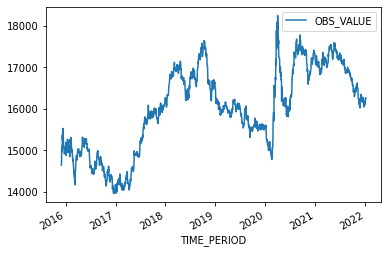

In [15]:
%matplotlib inline
ts.plot()

Indonesian Rupiah against EURO - data taken from ECB

**watch the 2020 spike in exchange ratio, which I think is an outflow of capital to US/Europe**

Now we import data from the Indonesian stock exchange, IDX - VanEck Vectors Indonesia Index ETF

In [16]:
import yfinance as yf

In [17]:
dft = yf.download("IDX",start='2015-12-01',end=today)
#dft.info()
#dft.tail(10)

[*********************100%***********************]  1 of 1 completed


In [18]:
#guess if you want to buy Low is more informative than high ;)
dftfil=dft.filter(['Low'])

<AxesSubplot:xlabel='Date'>

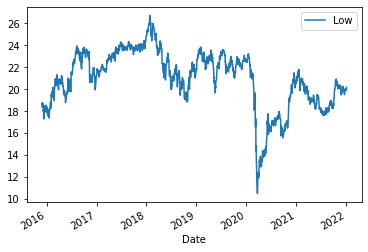

In [19]:
#%matplotlib inline
dftfil.plot()

*graph is IDX - VanEck Vectors Indonesia Index ETF*

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

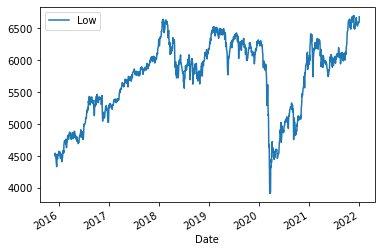

In [20]:
#Jakarta composite index
dftis = yf.download("^JKSE",start='2015-12-01',end=today)
dftfilis =dftis.filter(['Low'])
dftfilis.plot()

*jakarta stock exchange in Rupiah*

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

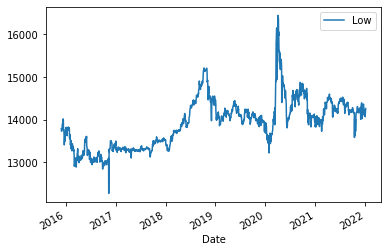

In [21]:
dftidr = yf.download("IDR=X",start='2015-12-01',end=today)
dftfilidr =dftidr.filter(['Low'])
dftfilidr.plot()


*this is the indonesian rupiah against the dollar*

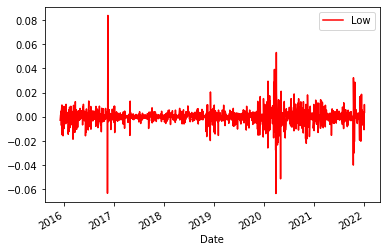

In [27]:
daily_changes = dftfilidr.pct_change(periods=1)
daily_changes.plot(color = 'r');

*this is the indonesian rupiah against the dollar daily change percentage*

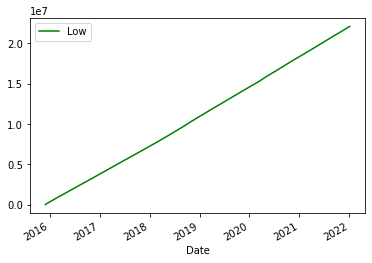

In [28]:
daily_changes = dftfilidr.cumsum()
daily_changes.plot(color = 'g');

In [23]:
#df = pd.merge(pd.merge(pd.merge(eurusd,gbpusd, on='Date'),usdgbp, on='Date'),usdeur, on='Date')
#dftidr = dftidr[['Low']].rename(columns={'Low': 'idr'})
dftis.tail()
dftidr.tail()
#dftis = dftis[['Low']].rename(columns={'Low': 'idx'})
dfcurstock = pd.merge(dftidr,dftis, on='Date')

dftcurstokfil = dfcurstock.filter(['idr','Low'])
dftcurstokfil.tail()
#dfcurstock.tail()
dftcurstokfil.plot()

TypeError: no numeric data to plot

in this graph there is a correlation between exchange rate and stock index, this begs the question if in the case of the indonesian stock exchange, we can use a significant change in currency rate as a signal to quit?

In order to get a clear idea, let's examine the 2020 covid crisis.

In [ ]:
dftcurstokfil.tail()

In [ ]:
testindex = dftcurstokfil.index.tolist()

In [ ]:
print (testindex[1])


In [ ]:
dftcurstokfil.loc('2021-12-30','2022-01-04')